In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier, log_evaluation, early_stopping
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import optuna

from sklearn.ensemble import VotingClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv("data.csv")
df=df.drop("id",axis=1)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


In [5]:
# checking if there are any null values
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


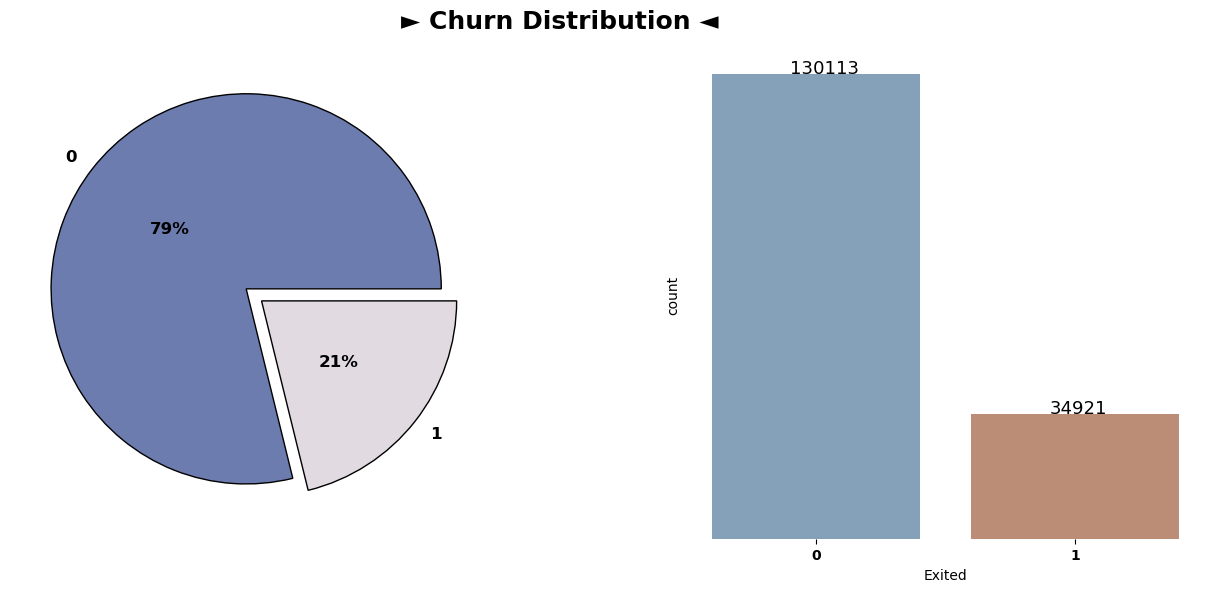

In [7]:
def plot_target(df: pd.DataFrame, col: str, title: str, pie_colors:list) -> None:
    
    fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,1])

    textprops={'fontsize': 12, 'weight': 'bold',"color": "black"}
    
    ax[0].pie(df[col].value_counts().to_list(),
            colors=pie_colors,
            labels=df[col].value_counts().index.to_list(),
            autopct='%1.f%%', 
            explode=([.05]*df[col].nunique()),
            pctdistance=0.5,
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops=textprops)

    sns.countplot(x = col, data=df, palette = "twilight_shifted", order=df[col].value_counts().to_dict().keys())
    
    for p, count in enumerate(df[col].value_counts().to_dict().values(),0):
        
        ax[1].text(p-0.1, count+(np.sqrt(count)), count, color='black', fontsize=13)
        
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    plt.yticks([])
    plt.box(False)
    fig.suptitle(x=0.56, t=f'► {title} Distribution ◄', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
plot_target(df,  col="Exited", 
            title="Churn", 
            pie_colors=["#6d7caf","#e1dae1","#a6615e","#d3c3f7","#f3f3af","#c0ebe9"])

Performing Exploratory Data Analysis for the data set 

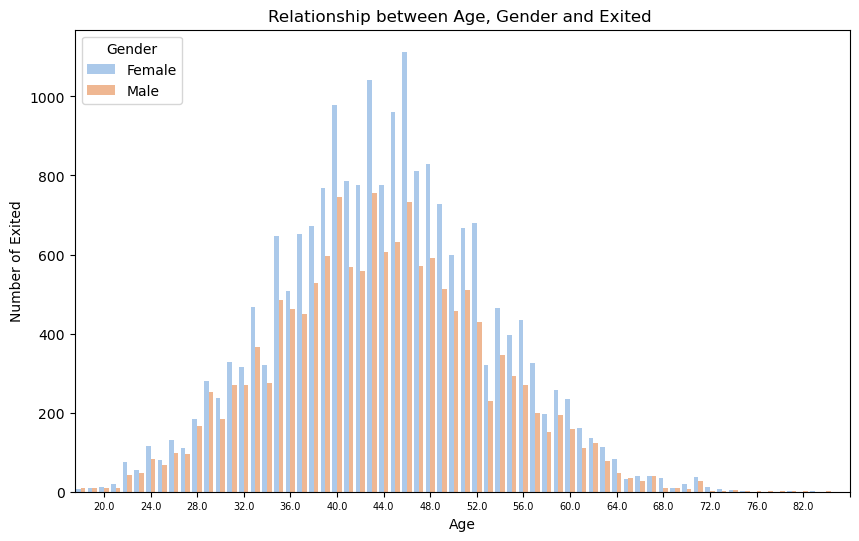

In [8]:
Exited=df[df.Exited==1]
Relationship=Exited.groupby("Gender")["Age"].value_counts().reset_index().sort_values(by="count",ascending=False)
Relationship
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='count', hue='Gender', data=Relationship, palette='pastel')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Exited')
plt.title('Relationship between Age, Gender and Exited ')
plt.xticks(np.arange(2,70,4),rotation=0, fontsize=7)

# Show the plot
plt.show()

Text(0.5, 1.0, 'Relationship between Age, Gender and Customer who remain')

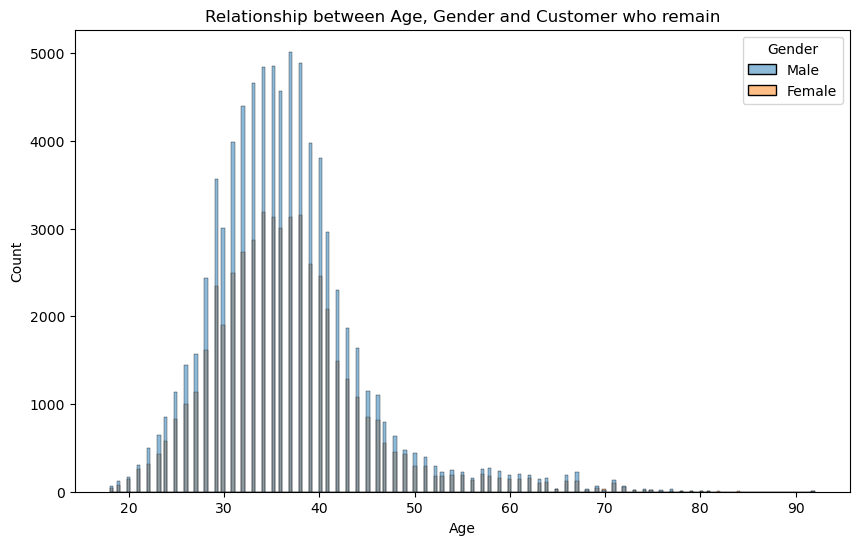

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df["Exited"]==0],x="Age",hue="Gender")
plt.title("Relationship between Age, Gender and Customer who remain")

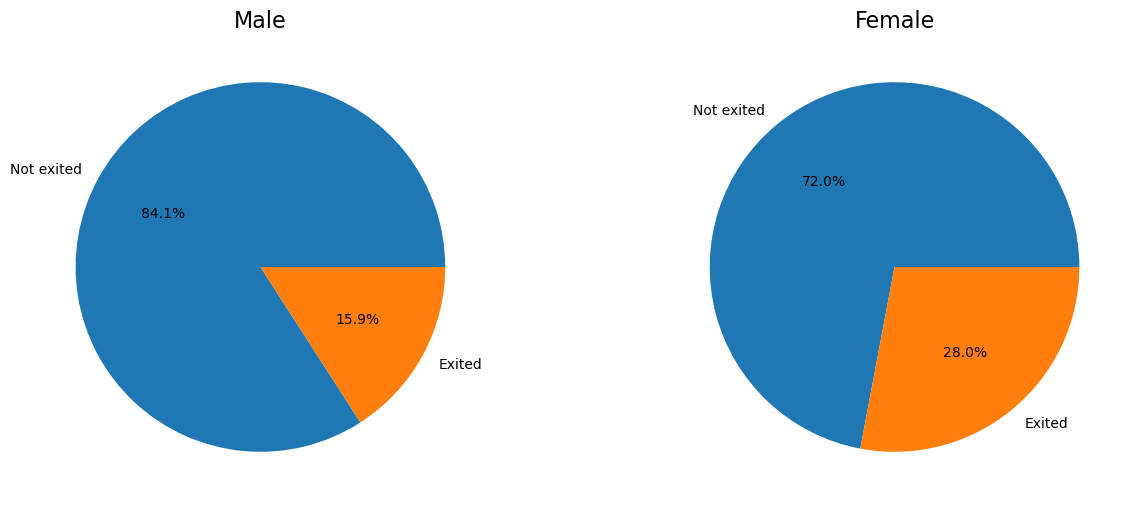

In [10]:
M=df[df["Gender"]=="Male"].Exited.value_counts()
Mf=df[df["Gender"]=="Female"].Exited.value_counts()
fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,2])
ax[0].set_title("Male",fontsize=16)
a=ax[0].pie(M/sum(M)*100,labels=["Not exited", "Exited"],autopct="%.1f%%")
ax[1].set_title("Female",fontsize=16)
a=ax[1].pie(Mf/sum(Mf)*100,labels=["Not exited", "Exited"],autopct="%.1f%%")

In [11]:
def percentageAge(x):
    y=df.groupby("Gender")["Age"].value_counts().reset_index()
    z=y[(y["Age"]==x.Age)*(y["Gender"]==x.Gender)]
    return 100*x["count"]/z.to_numpy()[0][2]

Exited=df[df.Exited==1]
Relationship=Exited.groupby("Gender")["Age"].value_counts().reset_index()
Relationship["Percentage"]=Relationship.apply(percentageAge,axis=1)

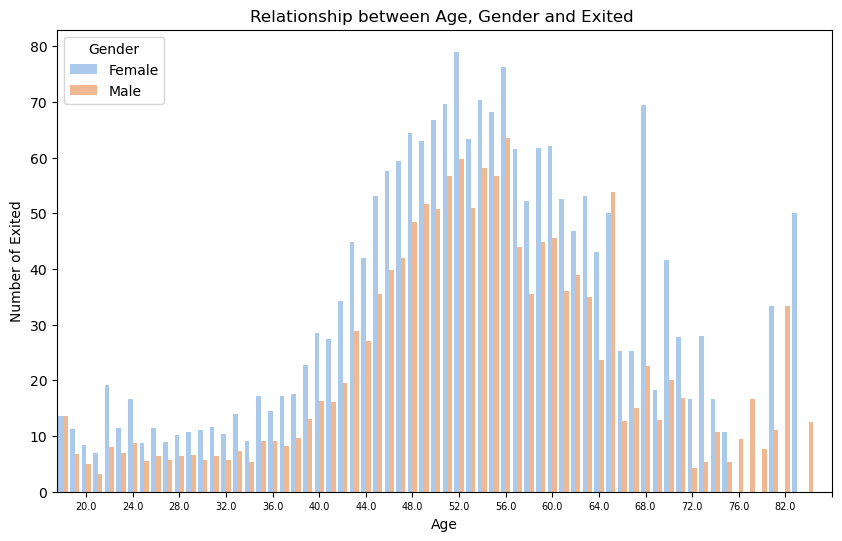

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='Percentage', hue='Gender', data=Relationship, palette='pastel')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Exited')
plt.title('Relationship between Age, Gender and Exited ')
plt.xticks(np.arange(2,70,4),rotation=0, fontsize=7)

# Show the plot
plt.show()

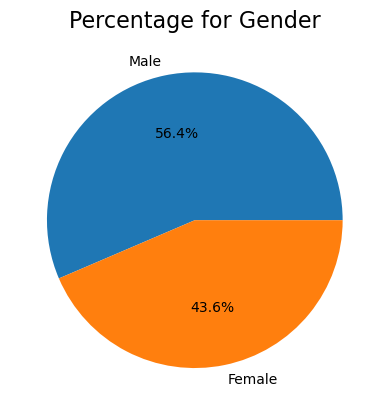

In [13]:
M=df.Gender.value_counts()
plt.title("Percentage for Gender",fontsize=16)
a=plt.pie(M/sum(M)*100,labels=["Male", "Female"],autopct="%.1f%%")

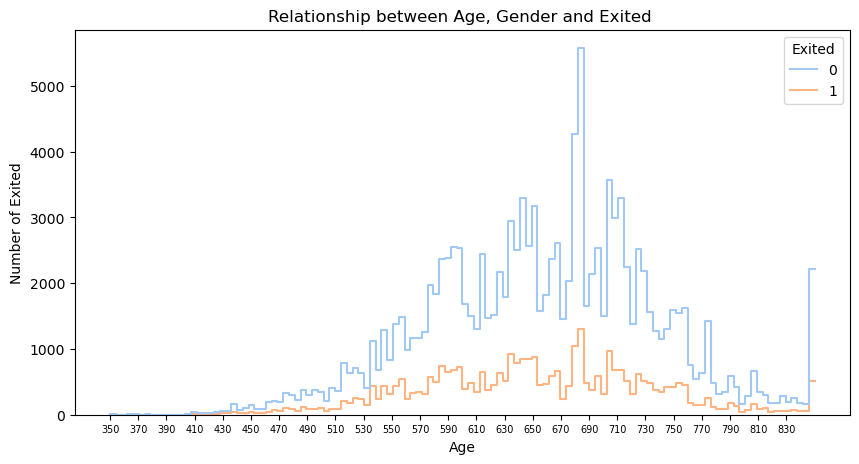

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(x='CreditScore', hue='Exited', data=df, palette='pastel',element="step", fill=False)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Exited')
plt.title('Relationship between Age, Gender and Exited ')
plt.xticks(np.arange(350,850,20),rotation=0, fontsize=7)

# Show the plot
plt.show()

<Axes: xlabel='CreditScore', ylabel='Density'>

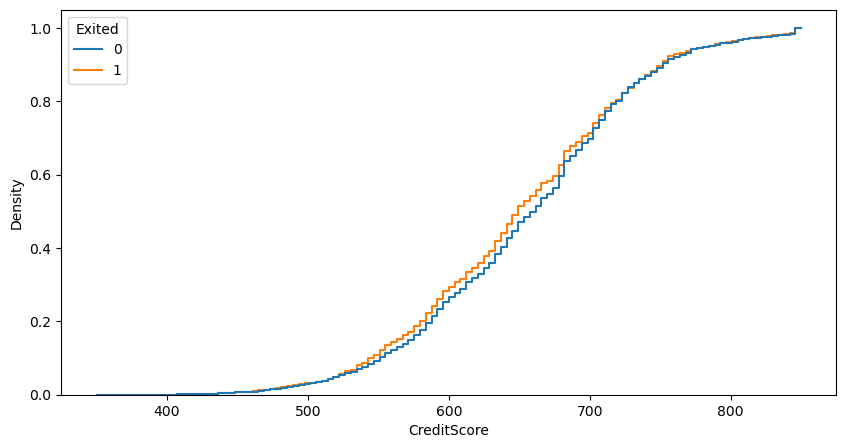

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(
    df,x='CreditScore', hue='Exited', element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

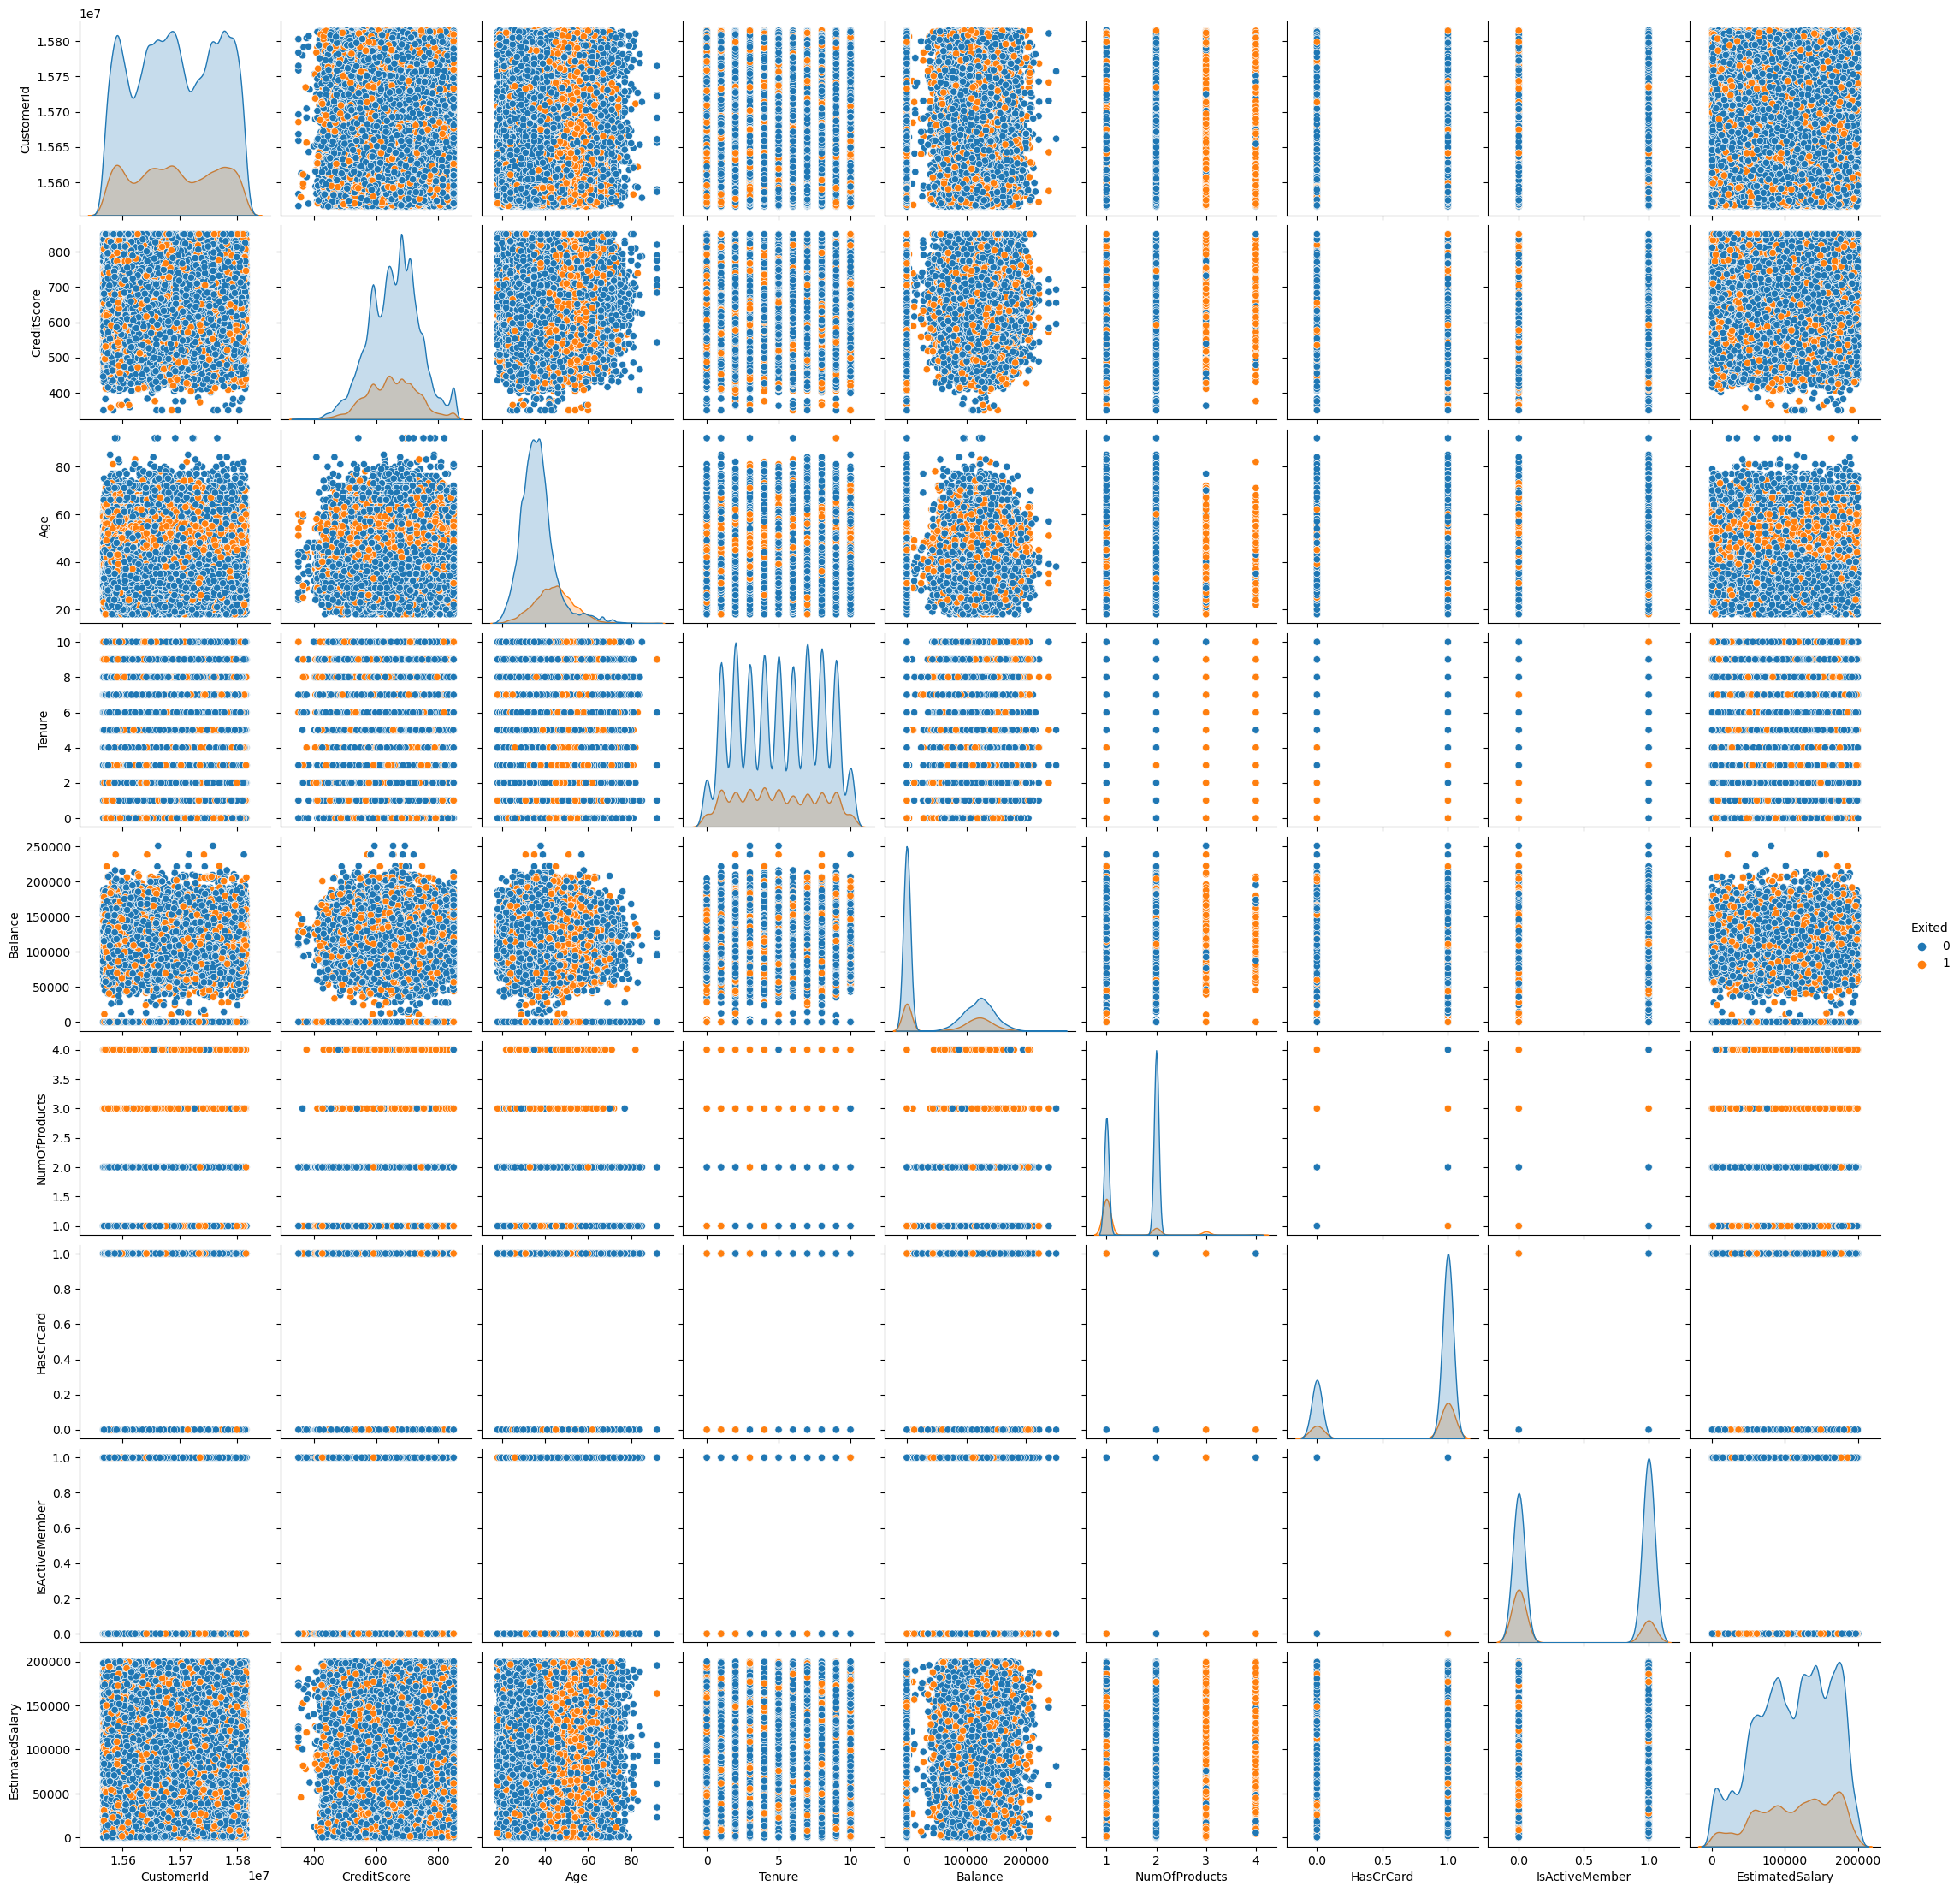

In [16]:
sns.pairplot(df, hue="Exited")

In [19]:
Z = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary','Exited']]
# Generate a sample correlation matrix
corr_matrix = Z.corr()

In [20]:
corr_matrix

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.027383
Age,-0.008918,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,0.340768
Tenure,0.000942,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,-0.019565
Balance,0.006973,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,0.129743
NumOfProducts,0.011361,-0.102195,0.007335,-0.361033,1.000000,0.005482,0.039736,-0.004285,-0.214554
HasCrCard,-0.002828,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,-0.022141
IsActiveMember,0.014790,0.003320,-0.005532,-0.015073,0.039736,-0.021034,1.000000,-0.008080,-0.210237
EstimatedSalary,-0.001820,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,0.018827
Exited,-0.027383,0.340768,-0.019565,0.129743,-0.214554,-0.022141,-0.210237,0.018827,1.000000
